In [8]:
# Imports and Setup

!pip install torchinfo

import os
import re
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchinfo import summary

from itertools import product
from torch.utils.data import Subset

import pickle
from google.colab import files

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Retrieve Data File

!curl -L -o cleaned_text.txt https://raw.githubusercontent.com/andlamb2002/5154-ml-project/main/cleaned_text.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1267k  100 1267k    0     0  1782k      0 --:--:-- --:--:-- --:--:-- 1782k


In [12]:
with open("cleaned_text.txt", "r", encoding="utf-8") as f:
    text = f.read()

tokens = text.split()

In [13]:
# Tokenization

word_counts = Counter(tokens)
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
word2idx = {word: i for i, word in enumerate(vocab)}
idx2word = {i: word for word, i in word2idx.items()}
vocab_size = len(vocab)

print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 23057


In [14]:
# Data Batching

class NextWordDataset(Dataset):
    def __init__(self, tokens, word2idx, max_seq_len=5):
        self.data = []
        for seq_len in range(1, max_seq_len + 1):
            for i in range(len(tokens) - seq_len):
                input_seq = tokens[i:i+seq_len]
                target = tokens[i+seq_len]
                self.data.append((input_seq, target))
        self.word2idx = word2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_seq, target = self.data[idx]
        input_ids = torch.tensor([self.word2idx[w] for w in input_seq], dtype=torch.long)
        target_id = torch.tensor(self.word2idx[target], dtype=torch.long)
        return input_ids, target_id

def collate_batch(batch):
    inputs, targets = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets = torch.stack(targets)
    return inputs_padded, targets

dataset = NextWordDataset(tokens, word2idx, max_seq_len=5)
loader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=collate_batch)

print(f"Number of Sequences: {len(dataset)}")
print(f"Number of Batches: {len(loader)}")

Number of Sequences: 1166190
Number of Batches: 4556


In [2]:
# BiLSTM Model

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
# Parameter Search

subset_size = int(len(dataset) * 0.10)
subset_dataset = Subset(dataset, range(subset_size))
subset_loader = DataLoader(subset_dataset, batch_size=256, shuffle=True, collate_fn=collate_batch)

param_grid = {
    "embed_size": [128, 256],
    "hidden_size": [256, 512],
    "lr": [0.004, 0.007, 0.01]
}

combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
results = []

for combo in combinations:
    params = dict(zip(param_names, combo))
    print(f"\nTraining with: {params}")

    model = BiLSTMModel(
        vocab_size,
        embed_size=params["embed_size"],
        hidden_size=params["hidden_size"],
        num_layers=2
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    criterion = nn.CrossEntropyLoss()

    for epoch in range(5):
        model.train()
        total_loss = 0
        correct = 0
        correct_top5 = 0
        total = 0

        for inputs, targets in subset_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == targets).sum().item()

            top5 = torch.topk(outputs, 5, dim=1).indices
            correct_top5 += sum([target in top for target, top in zip(targets, top5)])

            total += targets.size(0)

        print(f"Finished epoch {epoch+1}")

    avg_loss = total_loss / len(subset_loader)
    top1_acc = 100 * correct / total
    top5_acc = 100 * correct_top5 / total

    results.append({
        "params": params,
        "loss": avg_loss,
        "top1_accuracy": top1_acc,
        "top5_accuracy": top5_acc
    })

    print(f"Avg Loss: {avg_loss:.2f} | Top-1 Acc: {top1_acc:.2f}% | Top-5 Acc: {top5_acc:.2f}%")

best = max(results, key=lambda x: x["top5_accuracy"])
print("\nBest Configuration (by top5_accuracy):")
print(best)

results_df = pd.DataFrame(results)
display(results_df)


Training with: {'embed_size': 128, 'hidden_size': 256, 'lr': 0.004}
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5
Avg Loss: 4.62 | Top-1 Acc: 20.57% | Top-5 Acc: 40.28%

Training with: {'embed_size': 128, 'hidden_size': 256, 'lr': 0.007}
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5
Avg Loss: 4.81 | Top-1 Acc: 18.83% | Top-5 Acc: 36.94%

Training with: {'embed_size': 128, 'hidden_size': 256, 'lr': 0.01}
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5
Avg Loss: 5.04 | Top-1 Acc: 17.22% | Top-5 Acc: 33.80%

Training with: {'embed_size': 128, 'hidden_size': 512, 'lr': 0.004}
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5
Avg Loss: 4.56 | Top-1 Acc: 20.25% | Top-5 Acc: 39.89%

Training with: {'embed_size': 128, 'hidden_size': 512, 'lr': 0.007}
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5
Avg Loss: 5

,params,loss,top1_accuracy,top5_accuracy
0,"{'embed_size': 128, 'hidden_size': 256, 'lr': ...",4.618770,20.569547,40.283316
1,"{'embed_size': 128, 'hidden_size': 256, 'lr': ...",4.809063,18.829693,36.935662
2,"{'embed_size': 128, 'hidden_size': 256, 'lr': ...",5.044951,17.215034,33.800667
3,"{'embed_size': 128, 'hidden_size': 512, 'lr': ...",4.555965,20.249702,39.894871
4,"{'embed_size': 128, 'hidden_size': 512, 'lr': ...",5.013037,17.531449,34.121370
5,"{'embed_size': 128, 'hidden_size': 512, 'lr': ...",7.015965,13.183958,25.496703
6,"{'embed_size': 256, 'hidden_size': 256, 'lr': ...",4.569832,21.354153,41.193974
7,"{'embed_size': 256, 'hidden_size': 256, 'lr': ...",4.808666,19.309889,37.195483
8,"{'embed_size': 256, 'hidden_size': 256, 'lr': ...",5.174768,16.944923,32.842847
9,"{'embed_size': 256, 'hidden_size': 512, 'lr': ...",4.556013,20.848232,40.520841


In [16]:
# Model Overview

embed_size = 256
hidden_size = 256
num_layers = 2
learning_rate = 0.004

model = BiLSTMModel(
    vocab_size=vocab_size,
    embed_size=embed_size,
    hidden_size=hidden_size,
    num_layers=num_layers
).to(device)


summary(model, input_size=(1, 5), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTMModel                              [1, 23057]                --
├─Embedding: 1-1                         [1, 5, 256]               5,902,592
├─LSTM: 1-2                              [1, 5, 512]               2,629,632
├─Linear: 1-3                            [1, 23057]                11,828,241
Total params: 20,360,465
Trainable params: 20,360,465
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 30.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 81.44
Estimated Total Size (MB): 81.66

In [17]:
# Model Training

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)

train_losses = []
train_accuracies = []
train_top5_accuracies = []

for epoch in range(20):
    total_loss = 0
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, top1_pred = torch.max(outputs, 1)
        correct_top1 += (top1_pred == targets).sum().item()

        top5_preds = torch.topk(outputs, k=5, dim=1).indices
        for i in range(targets.size(0)):
            if targets[i] in top5_preds[i]:
                correct_top5 += 1

        total += targets.size(0)

    avg_loss = total_loss / len(loader)
    accuracy_top1 = 100 * correct_top1 / total
    accuracy_top5 = 100 * correct_top5 / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy_top1)
    train_top5_accuracies.append(accuracy_top5)

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.2f} | Top-1 Acc: {accuracy_top1:.2f}% | Top-5 Acc: {accuracy_top5:.2f}%")

Epoch 1 | Loss: 6.58 | Top-1 Acc: 11.55% | Top-5 Acc: 24.71%
Epoch 2 | Loss: 5.15 | Top-1 Acc: 18.21% | Top-5 Acc: 34.60%
Epoch 3 | Loss: 4.18 | Top-1 Acc: 24.85% | Top-5 Acc: 44.43%
Epoch 4 | Loss: 3.68 | Top-1 Acc: 29.59% | Top-5 Acc: 51.05%
Epoch 5 | Loss: 3.36 | Top-1 Acc: 33.18% | Top-5 Acc: 55.73%
Epoch 6 | Loss: 3.14 | Top-1 Acc: 35.73% | Top-5 Acc: 59.04%
Epoch 7 | Loss: 2.99 | Top-1 Acc: 37.73% | Top-5 Acc: 61.42%
Epoch 8 | Loss: 2.88 | Top-1 Acc: 39.18% | Top-5 Acc: 63.13%
Epoch 9 | Loss: 2.80 | Top-1 Acc: 40.34% | Top-5 Acc: 64.47%
Epoch 10 | Loss: 2.74 | Top-1 Acc: 41.30% | Top-5 Acc: 65.51%
Epoch 11 | Loss: 2.69 | Top-1 Acc: 41.97% | Top-5 Acc: 66.32%
Epoch 12 | Loss: 2.65 | Top-1 Acc: 42.53% | Top-5 Acc: 66.96%
Epoch 13 | Loss: 2.61 | Top-1 Acc: 43.04% | Top-5 Acc: 67.51%
Epoch 14 | Loss: 2.59 | Top-1 Acc: 43.45% | Top-5 Acc: 67.93%
Epoch 15 | Loss: 2.56 | Top-1 Acc: 43.85% | Top-5 Acc: 68.35%
Epoch 16 | Loss: 2.54 | Top-1 Acc: 44.21% | Top-5 Acc: 68.74%
Epoch 17 | Loss: 

Final Loss: 2.49
Top-1 Accuracy: 44.86%
Top-5 Accuracy: 69.44%


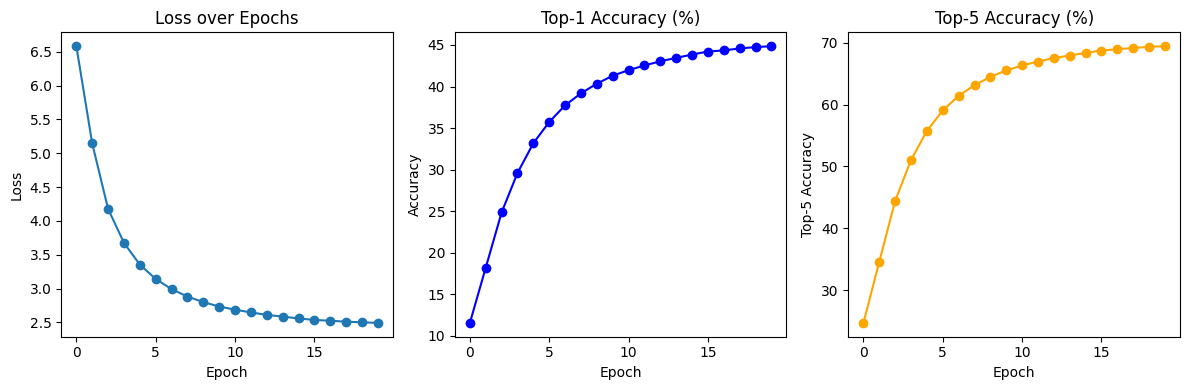

In [18]:
# Model Evaluation

final_loss = train_losses[-1]
final_top1 = train_accuracies[-1]
final_top5 = train_top5_accuracies[-1]

print(f"Final Loss: {final_loss:.2f}")
print(f"Top-1 Accuracy: {final_top1:.2f}%")
print(f"Top-5 Accuracy: {final_top5:.2f}%")

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(train_losses, marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,3,2)
plt.plot(train_accuracies, marker='o', color='blue')
plt.title("Top-1 Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1,3,3)
plt.plot(train_top5_accuracies, marker='o', color='orange')
plt.title("Top-5 Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Top-5 Accuracy")

plt.tight_layout()
plt.show()

In [22]:
# Save Model

def save_model(model, word2idx, idx2word, filename_prefix="nwp_model"):
    torch.save(model.state_dict(), f"{filename_prefix}.pth")

    metadata = {
        "word2idx": word2idx,
        "idx2word": idx2word,
        "vocab_size": model.embedding.num_embeddings,
        "embed_size": model.embedding.embedding_dim,
        "hidden_size": model.lstm.hidden_size,
        "num_layers": model.lstm.num_layers,
    }

    with open(f"{filename_prefix}_meta.pkl", "wb") as f:
        pickle.dump(metadata, f)

    print(f"Model and metadata saved with prefix '{filename_prefix}'")

filename_prefix="nwp_model"
save_model(model, word2idx, idx2word, filename_prefix=filename_prefix)

files.download(f"{filename_prefix}.pth")
files.download(f"{filename_prefix}_meta.pkl")

Model and metadata saved with prefix 'nwp_model'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# Load Model

def load_model(filename_prefix="nwp_model", device="cpu"):
    with open(f"{filename_prefix}_meta.pkl", "rb") as f:
        metadata = pickle.load(f)

    model = BiLSTMModel(
        vocab_size=metadata["vocab_size"],
        embed_size=metadata["embed_size"],
        hidden_size=metadata["hidden_size"],
        num_layers=metadata["num_layers"]
    ).to(device)

    model.load_state_dict(torch.load(f"{filename_prefix}.pth", map_location=device))
    model.eval()

    print(f"Model loaded from '{filename_prefix}.pth'")

    return model, metadata["word2idx"], metadata["idx2word"]

model, word2idx, idx2word = load_model(filename_prefix="nwp_model", device=device)

Model loaded from 'nwp_model.pth'


In [14]:
# Model Testing

def predict_next_words(model, input_text, top_k=5):
    model.eval()
    words = input_text.strip().lower().split()

    if len(words) > 5:
        words = words[-5:]

    if len(words) == 0:
        print("Please enter at least one word.")
        return

    input_ids = [word2idx.get(w, 0) for w in words]
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
    input_tensor = torch.nn.utils.rnn.pad_sequence(input_tensor, batch_first=True, padding_value=0)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        top_probs, top_idxs = torch.topk(probs, top_k)

    for i in range(top_k):
        word = idx2word[top_idxs[0][i].item()]
        prob = top_probs[0][i].item()
        print(f"{i+1}. {word} ({prob:.4f})")

while True:
    text_input = input("\nEnter a phrase for NWP (or 'quit'): ")
    if text_input.lower() in ['quit']:
        break
    predict_next_words(model, text_input, top_k=5)


Enter a phrase for NWP (or 'quit'): I am going
1. to (0.4950)
2. up (0.1709)
3. down (0.1170)
4. home (0.0994)
5. but (0.0222)

Enter a phrase for NWP (or 'quit'): We will go to
1. sleep (0.4503)
2. the (0.2747)
3. this (0.0453)
4. see (0.0210)
5. captain (0.0115)

Enter a phrase for NWP (or 'quit'): I don't
1. know (0.4099)
2. see (0.1548)
3. care (0.0967)
4. remember (0.0966)
5. wish (0.0895)

Enter a phrase for NWP (or 'quit'): What in the
1. world (0.4132)
2. the (0.2907)
3. country (0.0646)
4. his (0.0477)
5. he (0.0369)

Enter a phrase for NWP (or 'quit'): I love
1. you (0.6589)
2. and (0.1297)
3. him (0.0552)
4. her (0.0372)
5. it (0.0355)

Enter a phrase for NWP (or 'quit'): The middle
1. east (0.7088)
2. of (0.0867)
3. ages (0.0818)
4. temple (0.0282)
5. height (0.0177)

Enter a phrase for NWP (or 'quit'): The man with blue
1. and (0.4001)
2. eyes (0.3621)
3. flowers (0.1247)
4. crested (0.0190)
5. bells (0.0120)

Enter a phrase for NWP (or 'quit'): University of North
1. car